In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

import galhalo
from jsm_routines import SHMF, CSMF, SHMR, scatter_stat
import os

In [37]:
as_data = np.load("../../data/12_4_0/numpy/acc_surv_mass.npy")
as_red = np.load("../../data/12_4_0/numpy/acc_surv_redshift.npy")

In [40]:
Ms = SHMR(as_data)

In [41]:
Nreal = np.array([3000,2000,1000,500,300,100,50,5])

mat = np.zeros(shape=(Nreal.shape[0], 3, 50))

In [42]:
for i,N in enumerate(Nreal):

    choice = np.random.choice(as_data.shape[0], size=N)

    surv_massr, surv_CSMF_i = CSMF(Ms[choice], plot=False) # accreation mass of the surviving halos!
    
    mat[i] = surv_CSMF_i 

In [43]:
colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "cyan"]

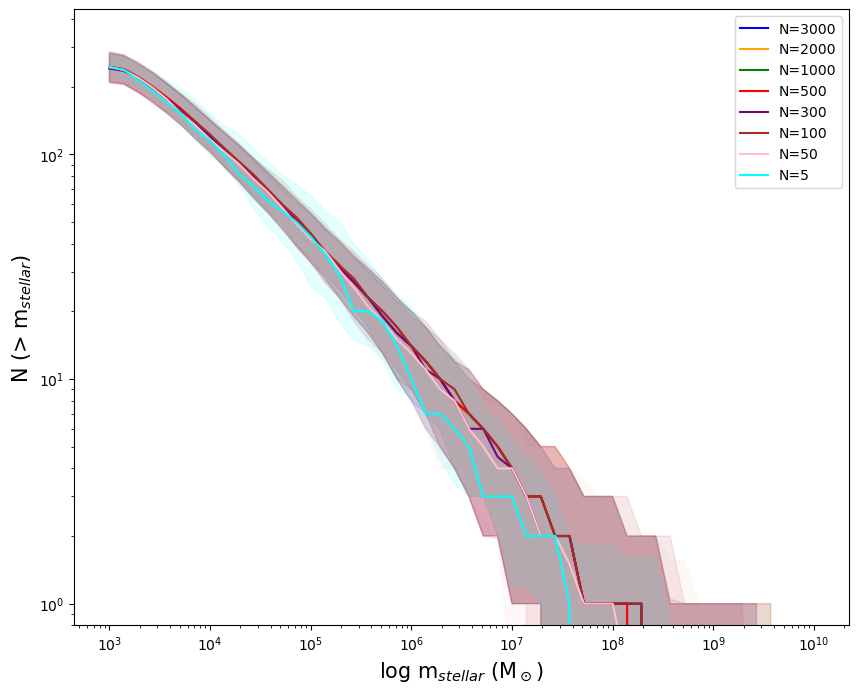

In [44]:
plt.figure(figsize=(10,8))

for i,val in enumerate(mat):
    
    plt.plot(surv_massr, val[1,:], color=colors[i], label="N="+str(Nreal[i]))
    plt.fill_between(surv_massr, y1=val[0, :], y2=val[2, :], alpha=0.1, color=colors[i])

plt.yscale("log")
plt.xscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.ylim(0.8)
plt.show()

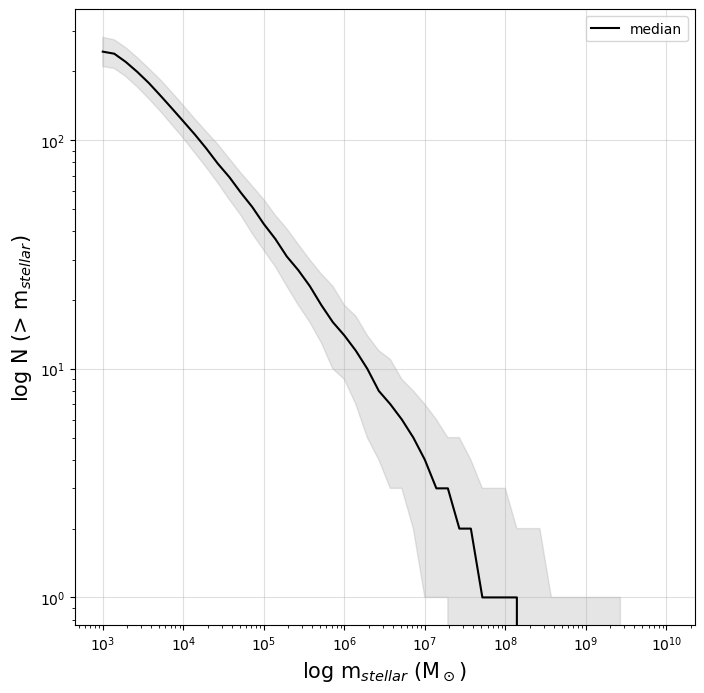

In [52]:
mass, det = CSMF(Ms)

In [68]:
stat = scatter_stat(mat, det)

mass_range = np.logspace(3,10,50)

m4 = stat[:,8]
m5 = stat[:,15]
m6 = stat[:,22]

returning a 8 by 50 matrix


/Users/jsmonzon/Research/SatGen/notebooks/../src/jsm_routines.py:268: RuntimeWarning: divide by zero encountered in divide
  
/Users/jsmonzon/Research/SatGen/notebooks/../src/jsm_routines.py:268: RuntimeWarning: invalid value encountered in divide
  


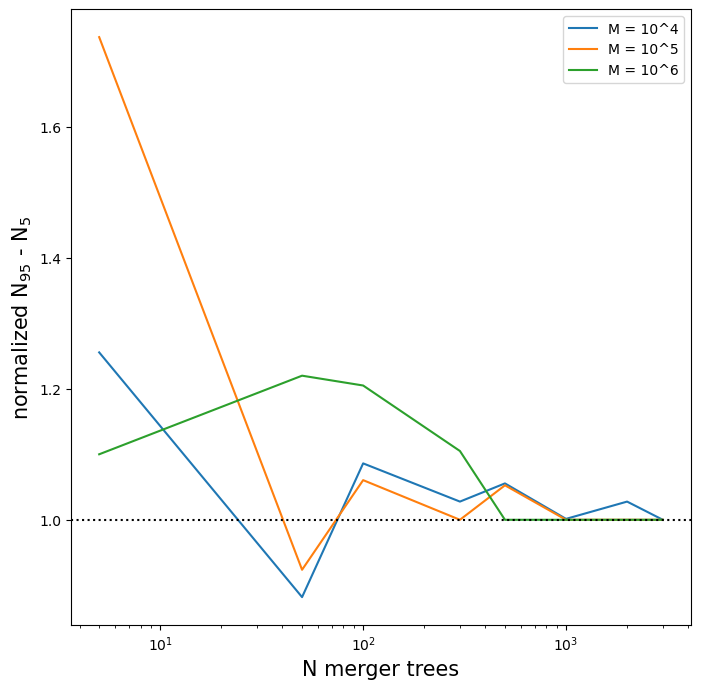

In [76]:
plt.figure(figsize=(8,8))


plt.plot(Nreal, m4, label="M = 10^4")
plt.plot(Nreal, m5, label="M = 10^5")
plt.plot(Nreal, m6, label="M = 10^6")
plt.axhline(1,ls=":", color="black")
plt.xscale("log")
plt.legend()
plt.xlabel("N merger trees", fontsize=15)
plt.ylabel("normalized $\mathrm{N}_{95}$ - $\mathrm{N}_{5}$", fontsize=15)
plt.show()